In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torchvision.models as models

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.bn0 = nn.BatchNorm2d(in_planes)

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(0.5)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(F.relu(self.bn0(x)))
        out = F.relu(self.bn2(out))
        out = self.conv2(self.dropout(out))
        out += self.shortcut(x)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)
        print(64*block.expansion)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [5,5,5])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet34()
    y = net(Variable(torch.randn(1,3,32,32)))
    print(y.size())

test()


64
torch.Size([1, 3])


In [4]:
net = ResNet18()
# net.add_module('final', nn.Linear(1000,16))
# net.fc = nn.Linear(2048,16)

# class action_net(net):
#     def __init__ ( self,pretrained = False ):
#         super ( action_net , self ). __init__ ()
#         net.__init__ ()
#         self.pretrained = False
#         self.final = nn.Linear(1000,16)
#         if torch.cuda.is_available():
#             self.final = self.final.cuda()
#     def forward(self,x):
#         return self.final(self.fc(x))
        

64


In [5]:
if(torch.cuda.is_available()):
    net = net.cuda()

In [6]:
torch.cuda.is_available()

True

In [7]:
# Y = np.load('labels.npy')
# Y = Y-1
# X = np.load('x.npy')
# X = np.array(X, dtype=float)

reading = np.load('reading_np.npy')
phn = np.load('phone_np.npy')
drinking = np.load('drinking_np.npy')
cleaning = np.load('cleaning_np.npy')
cutting = np.load('cutting_np.npy')
walking = np.load('walking_np.npy')

X = np.concatenate((reading, phn, drinking), axis = 0)
# X = np.concatenate((reading, phn, drinking), axis = 0)

y_reading = np.full(50,0)
y_phn = np.full(50,1)
y_drink = np.full(50,2)
y_cleaning = np.full(50,3)
y_cutting = np.full(50,4)
y_walking = np.full(50,5)

Y = np.concatenate((y_reading, y_phn, y_drink), axis = 0)


rX = np.load('test_data_np.npy')

train_x_lh = X[:,:,4:8,:]
train_x_rh = X[:,:,8:12,:]
train_x_ll = X[:,:,12:16,:]
train_x_rl = X[:,:,16:20,:]
train_x_t = X[:,:,0:4,:]

rtrain_x_lh = rX[:,:,4:8,:]
rtrain_x_rh = rX[:,:,8:12,:]
rtrain_x_ll = rX[:,:,12:16,:]
rtrain_x_rl = rX[:,:,16:20,:]
rtrain_x_t = rX[:,:,0:4,:]


rfinal_x = np.concatenate((rtrain_x_lh, rtrain_x_rh), axis=2)
rfinal_x = np.concatenate((rfinal_x, rtrain_x_t), axis=2)
rfinal_x = np.concatenate((rfinal_x, rtrain_x_rl), axis=2)
rfinal_x = np.concatenate((rfinal_x, rtrain_x_ll), axis=2)


final_x = np.concatenate((train_x_lh, train_x_rh), axis=2)
final_x = np.concatenate((final_x, train_x_t), axis=2)
final_x = np.concatenate((final_x, train_x_rl), axis=2)
final_x = np.concatenate((final_x, train_x_ll), axis=2)

X = final_x
rX = rfinal_x

In [8]:
Y.shape

(150,)

In [9]:
rX.shape

(7, 100, 20, 3)

In [10]:
#### Preprocessing to make the image.
min_ = X.min(axis=(0,1,2)).reshape(1,1,1,-1)
max_ = X.max(axis = (0,1,2)).reshape(1,1,1,-1)

min1_ = min_
max1_ = max_

min_ = np.repeat(min_, 150, axis=0)
min_ = np.repeat(min_, 100, axis=1)
min_ = np.repeat(min_, 20, axis=2)

max_ = np.repeat(max_, 150, axis=0)
max_ = np.repeat(max_, 100, axis=1)
max_ = np.repeat(max_, 20, axis=2)

X_normed = 255*(X - min_)/(max_ - min_).astype(np.int64)


In [11]:
#### Preprocessing to make the image.
rmin_ = rX.min(axis=(0,1,2)).reshape(1,1,1,-1)
rmax_ = rX.max(axis = (0,1,2)).reshape(1,1,1,-1)

rmin_ = np.repeat(min1_, 9, axis=0)
rmin_ = np.repeat(min1_, 100, axis=1)
rmin_ = np.repeat(min1_, 20, axis=2)

rmax_ = np.repeat(max1_, 9, axis=0)
rmax_ = np.repeat(max1_, 100, axis=1)
rmax_ = np.repeat(max1_, 20, axis=2)

rX_normed = 255*(rX - rmin_)/(rmax_ - rmin_).astype(np.int64)


In [12]:

# newest_X = []
# newest_Y = []
# counter = 0
# for x_del,y_del in zip(X_normed,Y):
#     counter +=1
#     if(y_del <= 6 or y_del==13):
#         newest_X.append(x_del)
#         newest_Y.append(y_del)
# X_normed = np.array(newest_X)
# Y = np.array(newest_Y)
        

In [13]:
from matplotlib.pyplot import imshow
from PIL import Image

import time
from pylab import *

new_X = []
for X_norm in X_normed:
    img = Image.fromarray(np.uint8(X_norm))
    img = img.resize((32, 32), Image.ANTIALIAS)
    img1 = img.transpose(Image.FLIP_LEFT_RIGHT)
    img2 = img.transpose(Image.FLIP_TOP_BOTTOM)
#     imshow(img)
#     show()
    time.sleep(0.0001)
    new_X.append(np.asarray( img, dtype="int32"))
    new_X.append(np.asarray( img1, dtype="int32"))
    new_X.append(np.asarray( img2, dtype="int32"))

Y = np.repeat(Y,3,axis = 0)



In [14]:
from matplotlib.pyplot import imshow
import time
from pylab import *

rnew_X = []
for rX_norm in rX_normed:
    rimg = Image.fromarray(np.uint8(rX_norm))
    rimg = rimg.resize((32, 32), Image.ANTIALIAS)
    rimg1 = rimg.transpose(Image.FLIP_LEFT_RIGHT)
    rimg2 = rimg.transpose(Image.FLIP_TOP_BOTTOM)
#     imshow(img)
#     show()
    time.sleep(0.0001)
    rnew_X.append(np.asarray( rimg, dtype="int32"))
    rnew_X.append(np.asarray( rimg1, dtype="int32"))
    rnew_X.append(np.asarray( rimg2, dtype="int32"))




In [15]:
# X_normed = np.pad(X_normed,[(0,0),(37,37),(102,102),(0,0)], 'constant')
# X = X_normed

new_X = np.array(new_X)
rnew_X = np.array(rnew_X)

In [16]:
X = new_X
rX = rnew_X

In [17]:
X.shape

(450, 32, 32, 3)

In [18]:
Y.shape

(450,)

In [19]:
N = Y.shape[0]
s = np.arange(X.shape[0])
np.random.shuffle(s)
shuffled_x = X[s]
shuffled_y = Y[s]


In [20]:
train_x = shuffled_x[0:int(0.8*N)]
train_y = shuffled_y[0:int(0.8*N)]
test_x = shuffled_x[int(0.8*N):]
test_y = shuffled_y[int(0.8*N):]

In [21]:
train_x = Variable(torch.from_numpy(train_x)).float().cuda()
train_x = train_x.permute(0,3,1,2).contiguous()
test_x = Variable(torch.from_numpy(test_x)).float().cuda()
test_x = test_x.permute(0,3,1,2).contiguous()
labels = Variable(torch.from_numpy(train_y)).long().cuda()
test_y = Variable(torch.from_numpy(test_y)).long().cuda()



In [22]:
test_y.shape

torch.Size([90])

In [23]:
# for i in range(10):
#     img = Image.fromarray(np.uint8(shuffled_x[i]))
#     img.resize((32, 32), Image.ANTIALIAS)
#     img.show()

In [24]:
BATCH_SIZE = 32
num_epochs = 50
num_batches = train_x.shape[0]/BATCH_SIZE
num_test_batches = test_x.shape[0]/BATCH_SIZE
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01,momentum = 0.9, weight_decay = 0.0001)

In [25]:
def pred(x):
    out = net(x)
    return np.argmax(out.data.cpu().numpy(), axis=1)

In [26]:
train_plot = []
test_plot = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    if(epoch%75 == 74):
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/10
    running_loss = 0
    test_running_loss = 0
    for batch in range(int(num_test_batches)):
        batch_x = test_x[BATCH_SIZE*batch:BATCH_SIZE*(batch+1)]
        out = net(batch_x)
        loss = criterion(out,test_y[BATCH_SIZE*batch:BATCH_SIZE*(batch+1)].cuda())
        test_running_loss += loss.data[0]
    test_running_loss = test_running_loss/int(num_test_batches)
    test_plot.append(test_running_loss)
    test_acc.append(np.mean(pred(test_x) == test_y.data.cpu().numpy()))

    for batch in range(int(num_batches)):
        optimizer.zero_grad()
        batch_x = train_x[BATCH_SIZE*batch:BATCH_SIZE*(batch+1)]
        out = net(batch_x)
        loss = criterion(out,labels[BATCH_SIZE*batch:BATCH_SIZE*(batch+1)])
        running_loss += loss.data[0]
        loss.backward()
        optimizer.step()
    running_loss = running_loss / int(num_batches)
    train_plot.append(running_loss)
    train_acc.append(np.mean(pred(train_x) == labels.data.cpu().numpy()))
    print ('Epoch [%d/%d], Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, running_loss, test_running_loss))

Epoch [1/50], Loss: 0.8724, Test Loss: 1.0439
Epoch [2/50], Loss: 0.5207, Test Loss: 0.6567
Epoch [3/50], Loss: 0.3616, Test Loss: 0.4325
Epoch [4/50], Loss: 0.2633, Test Loss: 0.2831
Epoch [5/50], Loss: 0.1806, Test Loss: 0.2238
Epoch [6/50], Loss: 0.1623, Test Loss: 0.1668
Epoch [7/50], Loss: 0.1444, Test Loss: 0.1413
Epoch [8/50], Loss: 0.1365, Test Loss: 0.2231
Epoch [9/50], Loss: 0.1149, Test Loss: 0.1405
Epoch [10/50], Loss: 0.0804, Test Loss: 0.0993
Epoch [11/50], Loss: 0.0531, Test Loss: 0.1214
Epoch [12/50], Loss: 0.1666, Test Loss: 0.1350
Epoch [13/50], Loss: 0.1627, Test Loss: 0.4082
Epoch [14/50], Loss: 0.1131, Test Loss: 0.3226
Epoch [15/50], Loss: 0.0815, Test Loss: 0.0848
Epoch [16/50], Loss: 0.0604, Test Loss: 0.1732
Epoch [17/50], Loss: 0.0688, Test Loss: 0.2016
Epoch [18/50], Loss: 0.0364, Test Loss: 0.1033
Epoch [19/50], Loss: 0.0310, Test Loss: 0.2074
Epoch [20/50], Loss: 0.0547, Test Loss: 0.2770
Epoch [21/50], Loss: 0.0202, Test Loss: 0.0944
Epoch [22/50], Loss: 0

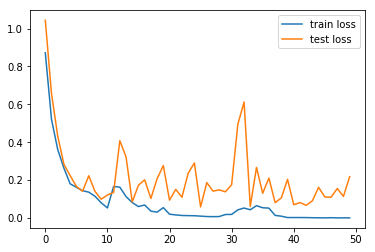

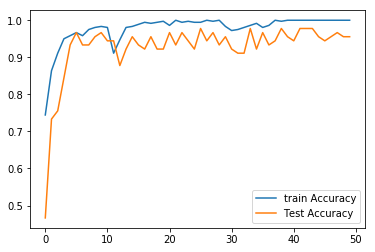

In [34]:
def plotGraph(y1,y2,x, lab1 = "train loss", lab2 = "test loss"):
    plt.plot(x,y1, label = lab1)
    plt.plot(x,y2, label=lab2)
    plt.legend()
    plt.show()
plotGraph(train_plot, test_plot, [i for i in range(num_epochs)])
plotGraph(train_acc, test_acc, [i for i in range(num_epochs)], "train Accuracy", "Test Accuracy")

In [28]:
"""
0 : Reading
1: Phone
2: Drinking
3: Cleaning
4: Cutting
#5: optional(Walking)
"""

'\n0 : Reading\n1: Phone\n2: Drinking\n3: Cleaning\n4: Cutting\n#5: optional(Walking)\n'

In [29]:
print(np.mean(pred(test_x) == test_y.data.cpu().numpy()))
print(np.mean(pred(train_x) == labels.data.cpu().numpy()))

0.9444444444444444
1.0


In [30]:
r_x = Variable(torch.from_numpy(rX)).float().cuda()
r_x = r_x
r_x.shape
arr = net(r_x.permute(0,3,1,2)).data.cpu().numpy()
print(np.argmax(arr,axis =1))
for x in arr:
    print(np.argsort(x,axis =0))

[2 0 2 0 0 0 2 0 0 1 1 1 1 1 2 2 2 2 2 0 0]
[1 0 2]
[1 2 0]
[1 0 2]
[1 2 0]
[1 2 0]
[1 2 0]
[1 0 2]
[1 2 0]
[1 2 0]
[2 0 1]
[2 0 1]
[0 2 1]
[2 0 1]
[2 0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[1 0 2]
[1 2 0]
[1 2 0]


In [31]:
actions = "drink", "eat", "read book", "call cellphone", "write on a paper", "use laptop", "use vacuum cleaner", "cheer up", "sit still", "toss paper", "play game", "lie down on sofa", "walk", "play guitar", "stand up", "sit down"

In [32]:

for x in arr:
    for i in np.argsort(x,axis = 0):
        print(actions[i], " ",)
    print( "\n")

eat  
drink  
read book  


eat  
read book  
drink  


eat  
drink  
read book  


eat  
read book  
drink  


eat  
read book  
drink  


eat  
read book  
drink  


eat  
drink  
read book  


eat  
read book  
drink  


eat  
read book  
drink  


read book  
drink  
eat  


read book  
drink  
eat  


drink  
read book  
eat  


read book  
drink  
eat  


read book  
drink  
eat  


drink  
eat  
read book  


drink  
eat  
read book  


drink  
eat  
read book  


drink  
eat  
read book  


eat  
drink  
read book  


eat  
read book  
drink  


eat  
read book  
drink  




In [33]:
reading = np.load('reading_np.npy')
phn = np.load('phone_np.npy')
drinking = np.load('drinking_np.npy')
cleaning = np.load('cleaning_np.npy')
#walking = np.load('walking_np.npy')
cutting = np.load('cutting_np.npy')